Loading and preprocessing data...
Creating enhanced customer features...
Scaling features...
Finding optimal number of clusters...


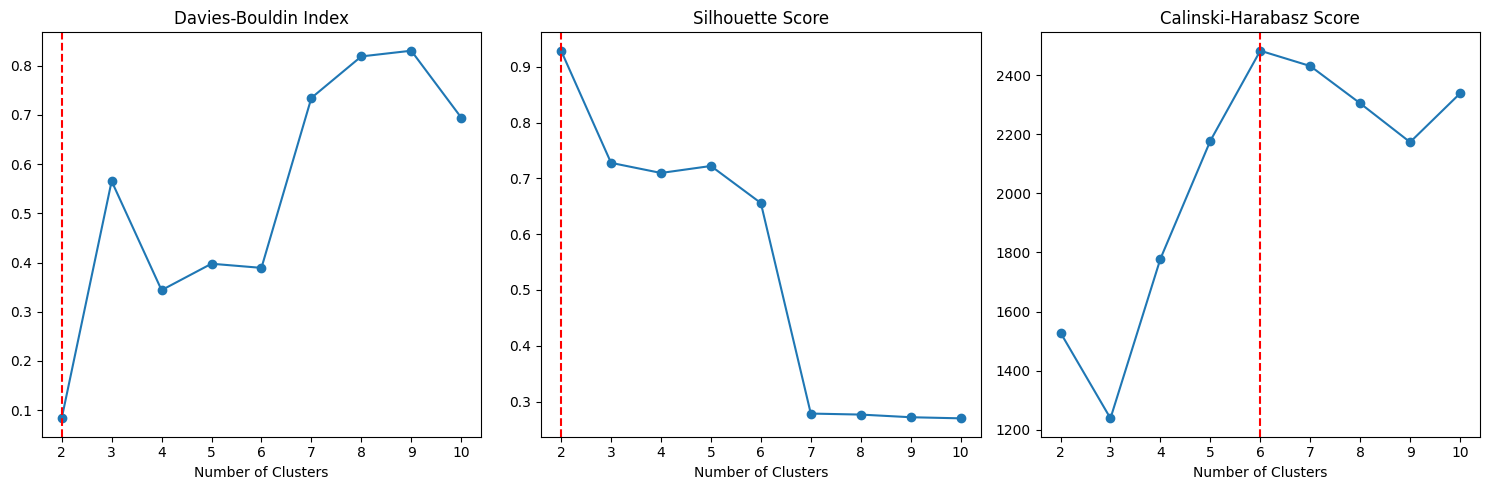

Optimal number of clusters: 2
Performing clustering...
Analyzing clusters...

KMEANS CLUSTERING ANALYSIS
Number of clusters: 2
Davies-Bouldin Index: 0.08
Silhouette Score: 0.93
Calinski-Harabasz Score: 1528.50

Cluster 0
Size: 189 customers (94.5%)

Key Metrics:
- Average Total Spent: $3212.18
- Average Order Value: $660.86
- Transaction Count: 4.9
- Days Since Last Purchase: -296.6
- Purchase Frequency: 0.032
- Engagement Score: 0.299
- Customer Value: 1823.34

Seasonal Patterns:
- Month 1: $nan
- Month 2: $nan
- Month 3: $nan
- Month 4: $nan
- Month 5: $nan
- Month 6: $nan
- Month 7: $nan
- Month 8: $nan
- Month 9: $nan
- Month 10: $nan
- Month 11: $nan
- Month 12: $nan

Cluster 1
Size: 11 customers (5.5%)

Key Metrics:
- Average Total Spent: $361.80
- Average Order Value: $361.80
- Transaction Count: 1.0
- Days Since Last Purchase: -150.2
- Purchase Frequency: 1.000
- Engagement Score: 0.593
- Customer Value: 245.89

Seasonal Patterns:
- Month 1: $nan
- Month 2: $nan
- Month 3: $nan

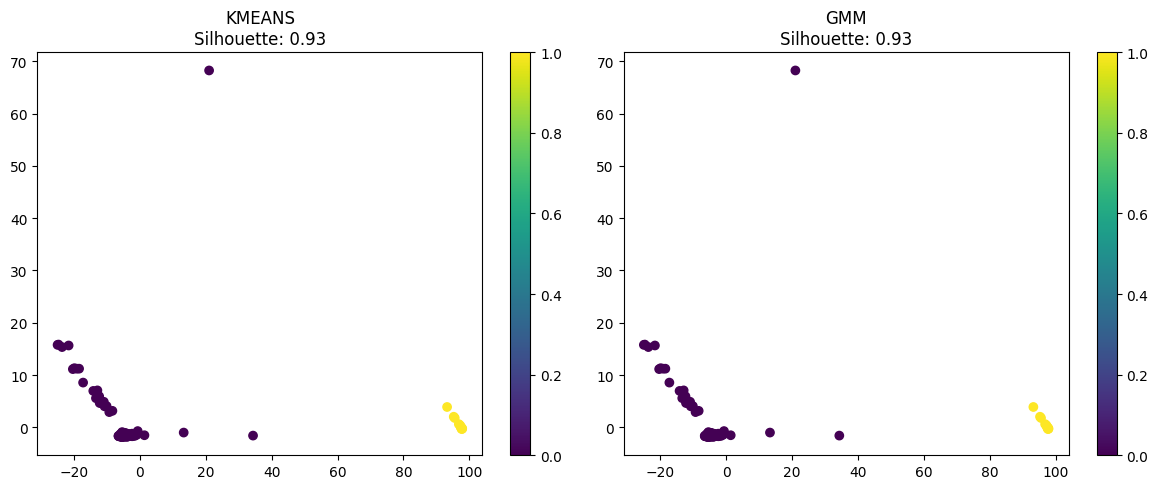

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(customers_path, products_path, transactions_path):
    # Load data
    customers = pd.read_csv(customers_path)
    products = pd.read_csv(products_path)
    transactions = pd.read_csv(transactions_path)

    # Convert dates
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], errors='coerce')
    transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], errors='coerce')

    # Fill missing dates with median
    customers['SignupDate'] = customers['SignupDate'].fillna(customers['SignupDate'].median())
    transactions['TransactionDate'] = transactions['TransactionDate'].fillna(transactions['TransactionDate'].median())

    # Merge datasets
    merged = transactions.merge(customers, on='CustomerID', how='left').merge(products, on='ProductID', how='left')

    # Calculate tenure (ensure current_date is correctly defined)
    current_date = pd.to_datetime('2024-01-01')
    merged['Tenure'] = (current_date - merged['SignupDate']).dt.days

    return customers, products, merged

def create_enhanced_features(customers, merged):
    # Basic customer metrics
    customer_metrics = merged.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'std', 'max', 'count'],
        'Quantity': ['sum', 'mean', 'std'],
        'ProductID': 'nunique',
        'TransactionDate': ['min', 'max']
    }).fillna(0)

    # Flatten column names
    customer_metrics.columns = [
        'TotalSpent', 'AvgOrderValue', 'OrderValueStd', 'MaxOrderValue', 'TransactionCount',
        'TotalQuantity', 'AvgQuantity', 'QuantityStd', 'UniqueProducts',
        'FirstPurchaseDate', 'LastPurchaseDate'
    ]

    # Calculate time-based features
    current_date = pd.to_datetime('2024-01-01')  # Use a fixed current date
    customer_metrics['DaysSinceLastPurchase'] = (
        current_date - pd.to_datetime(customer_metrics['LastPurchaseDate'])
    ).dt.days

    customer_metrics['PurchaseTimespan'] = (
        pd.to_datetime(customer_metrics['LastPurchaseDate']) -
        pd.to_datetime(customer_metrics['FirstPurchaseDate'])
    ).dt.days

    # Calculate purchase frequency
    customer_metrics['PurchaseFrequency'] = (
        customer_metrics['TransactionCount'] /
        customer_metrics['PurchaseTimespan'].replace(0, 1)
    )

    # Calculate average time between purchases
    customer_metrics['AvgDaysBetweenPurchases'] = (
        customer_metrics['PurchaseTimespan'] /
        customer_metrics['TransactionCount'].replace(0, 1)
    )



    # Seasonal analysis
    seasonal_purchases = merged.copy()
    seasonal_purchases['Month'] = seasonal_purchases['TransactionDate'].dt.month

    # Ensure all months are included
    seasonal_quarters = seasonal_purchases.groupby(['CustomerID', 'Month'])['TotalValue'].sum().unstack(fill_value=0)

    # Add missing months (if any)
    for month in range(1, 13):
        if month not in seasonal_quarters.columns:
            seasonal_quarters[month] = 0

    # Reorder columns to ensure months are in order
    seasonal_quarters = seasonal_quarters.reindex(columns=range(1, 13), fill_value=0)




    # Merge all features
    customer_features = customers.merge(
        customer_metrics,
        left_on='CustomerID',
        right_index=True,
        how='left'
    )

    # Add seasonal features
    for month in range(1, 13):
        if month in seasonal_quarters.columns:
            customer_features[f'Month_{month}_Sales'] = seasonal_quarters[month]
        else:
            customer_features[f'Month_{month}_Sales'] = 0

    # Calculate customer value metrics
    customer_features['CustomerValue'] = (
        customer_features['TotalSpent'] * 0.5 +
        customer_features['TransactionCount'] * 0.3 +
        customer_features['UniqueProducts'] * 0.2
    )

    # Calculate customer engagement score
    customer_features['EngagementScore'] = (
        (1 / (1 + customer_features['DaysSinceLastPurchase'])) * 0.4 +
        customer_features['PurchaseFrequency'] * 0.3 +
        (customer_features['UniqueProducts'] / customer_features['TransactionCount'].replace(0, 1)) * 0.3
    )

    # Handle skewed features
    skewed_features = [
        'TotalSpent', 'AvgOrderValue', 'OrderValueStd', 'MaxOrderValue',
        'TransactionCount', 'TotalQuantity', 'QuantityStd'
    ]

    for feature in skewed_features:
        if feature in customer_features.columns:
            customer_features[feature] = customer_features[feature].clip(lower=0)
            customer_features[feature] = np.log1p(customer_features[feature])

    # Create dummy variables for categorical features
    customer_features = pd.get_dummies(customer_features, columns=['Region'])

    # Drop unnecessary columns
    columns_to_drop = ['CustomerID', 'FirstPurchaseDate', 'LastPurchaseDate', 'SignupDate']
    customer_features = customer_features.drop(columns=columns_to_drop, errors='ignore')

    return customer_features

def scale_features(features):
    numeric_features = features.select_dtypes(include=[np.number])

    # Handle any remaining missing values
    imputer = SimpleImputer(strategy='median')
    imputed_features = imputer.fit_transform(numeric_features)

    # Use RobustScaler for better handling of outliers
    scaler = RobustScaler()
    scaled = scaler.fit_transform(imputed_features)

    return scaled, scaler

def find_optimal_clusters(X, max_clusters=10):
    metrics = {
        'db_score': [],
        'silhouette': [],
        'calinski': []
    }

    for n in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42)
        labels = kmeans.fit_predict(X)

        metrics['db_score'].append(davies_bouldin_score(X, labels))
        metrics['silhouette'].append(silhouette_score(X, labels))
        metrics['calinski'].append(calinski_harabasz_score(X, labels))

    # Plot evaluation metrics
    plt.figure(figsize=(15, 5))

    titles = ['Davies-Bouldin Index', 'Silhouette Score', 'Calinski-Harabasz Score']
    for i, (metric, scores) in enumerate(metrics.items()):
        plt.subplot(1, 3, i+1)
        plt.plot(range(2, max_clusters + 1), scores, marker='o')

        if metric == 'db_score':
            optimal = np.argmin(scores) + 2
        else:
            optimal = np.argmax(scores) + 2

        plt.axvline(x=optimal, color='r', linestyle='--')
        plt.title(titles[i])
        plt.xlabel('Number of Clusters')

    plt.tight_layout()
    plt.show()

    # Return optimal number based on Silhouette score
    return np.argmax(metrics['silhouette']) + 2

def perform_clustering(X, n_clusters):
    results = {}

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    results['kmeans'] = {
        'labels': kmeans_labels,
        'model': kmeans,
        'metrics': {
            'db_score': davies_bouldin_score(X, kmeans_labels),
            'silhouette': silhouette_score(X, kmeans_labels),
            'calinski': calinski_harabasz_score(X, kmeans_labels)
        }
    }

    # Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    results['gmm'] = {
        'labels': gmm_labels,
        'model': gmm,
        'metrics': {
            'db_score': davies_bouldin_score(X, gmm_labels),
            'silhouette': silhouette_score(X, gmm_labels),
            'calinski': calinski_harabasz_score(X, gmm_labels)
        }
    }

    return results

def analyze_clusters(customer_features, clustering_results):
    for method, result in clustering_results.items():
        labels = result['labels']
        metrics = result['metrics']

        print(f"\n{method.upper()} CLUSTERING ANALYSIS")
        print("=" * 50)
        print(f"Number of clusters: {len(np.unique(labels))}")
        print(f"Davies-Bouldin Index: {metrics['db_score']:.2f}")
        print(f"Silhouette Score: {metrics['silhouette']:.2f}")
        print(f"Calinski-Harabasz Score: {metrics['calinski']:.2f}")

        # Add cluster labels to features
        df_analysis = customer_features.copy()
        df_analysis['Cluster'] = labels

        # Analyze each cluster
        for cluster in sorted(df_analysis['Cluster'].unique()):
            cluster_data = df_analysis[df_analysis['Cluster'] == cluster]

            print(f"\nCluster {cluster}")
            print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(df_analysis)*100:.1f}%)")

            # Key metrics (reverse log transformation where needed)
            metrics = {
                'Average Total Spent': np.expm1(cluster_data['TotalSpent'].mean()),
                'Average Order Value': np.expm1(cluster_data['AvgOrderValue'].mean()),
                'Transaction Count': np.expm1(cluster_data['TransactionCount'].mean()),
                'Days Since Last Purchase': cluster_data['DaysSinceLastPurchase'].mean(),
                'Purchase Frequency': cluster_data['PurchaseFrequency'].mean(),
                'Engagement Score': cluster_data['EngagementScore'].mean(),
                'Customer Value': cluster_data['CustomerValue'].mean()
            }

            print("\nKey Metrics:")
            print(f"- Average Total Spent: ${metrics['Average Total Spent']:.2f}")
            print(f"- Average Order Value: ${metrics['Average Order Value']:.2f}")
            print(f"- Transaction Count: {metrics['Transaction Count']:.1f}")
            print(f"- Days Since Last Purchase: {metrics['Days Since Last Purchase']:.1f}")
            print(f"- Purchase Frequency: {metrics['Purchase Frequency']:.3f}")
            print(f"- Engagement Score: {metrics['Engagement Score']:.3f}")
            print(f"- Customer Value: {metrics['Customer Value']:.2f}")

            # Seasonal patterns
            seasonal_cols = [col for col in cluster_data.columns if 'Month_' in col]
            seasonal_means = cluster_data[seasonal_cols].mean()

            print("\nSeasonal Patterns:")
            for month in range(1, 13):
                col = f'Month_{month}_Sales'
                if col in seasonal_means:
                    print(f"- Month {month}: ${seasonal_means[col]:.2f}")

def visualize_clusters(X, clustering_results):
    # Perform PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create visualization
    n_methods = len(clustering_results)
    plt.figure(figsize=(6*n_methods, 5))

    for i, (method, result) in enumerate(clustering_results.items(), 1):
        plt.subplot(1, n_methods, i)
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=result['labels'], cmap='viridis')
        plt.title(f'{method.upper()}\nSilhouette: {result["metrics"]["silhouette"]:.2f}')
        plt.colorbar(scatter)

    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing data...")
    customers, products, merged = load_and_preprocess_data(
        'Customers.csv',
        'Products.csv',
        'Transactions.csv'
    )

    print("Creating enhanced customer features...")
    customer_features = create_enhanced_features(customers, merged)

    print("Scaling features...")
    X_scaled, _ = scale_features(customer_features)

    print("Finding optimal number of clusters...")
    n_clusters = find_optimal_clusters(X_scaled)
    print(f"Optimal number of clusters: {n_clusters}")

    print("Performing clustering...")
    clustering_results = perform_clustering(X_scaled, n_clusters)

    print("Analyzing clusters...")
    analyze_clusters(customer_features, clustering_results)

    print("Visualizing results...")
    visualize_clusters(X_scaled, clustering_results)

if __name__ == "__main__":
    main()